## Problem 2 Using Machine learning


In [14]:
# ==================== SVM CLASSIFICATION ====================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the CSV file
df = pd.read_csv("../classification_both/target-system.csv")
#df = pd.read_csv("../classification_overall/target-system.csv")


print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['class'].value_counts())
print(f"\nMissing values:")
print(df.isnull().sum())

# Preprocess the data
print("\n" + "="*50)
print("PREPROCESSING DATA")
print("="*50)

# Fill missing values
df['description'] = df['description'].fillna('')
df['vendor'] = df['vendor'].fillna('Unknown')
df['product'] = df['product'].fillna('Unknown')
df['class'] = df['class'].fillna('Other')

# Combine text features for better classification
# We'll use description + vendor + product
df['combined_text'] = df['description'] + ' ' + df['vendor'] + ' ' + df['product']

print(f"Total samples after preprocessing: {len(df)}")


Dataset loaded successfully!
Shape: (892, 5)

Columns: ['id', 'description', 'vendor', 'product', 'class']

Class distribution:
class
Other         312
PC            208
Enterprise    146
Home          102
SCADA          86
Mobile         38
Name: count, dtype: int64

Missing values:
id               0
description      0
vendor         378
product        284
class            0
dtype: int64

PREPROCESSING DATA
Total samples after preprocessing: 892


In [15]:

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['class'])

print(f"\nLabel encoding:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name}: {i}")

# Split the data
print("\n" + "="*50)
print("SPLITTING DATA")
print("="*50)

X = df['combined_text']  # Using combined text features
y = df['label_encoded']

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")



Label encoding:
  Enterprise: 0
  Home: 1
  Mobile: 2
  Other: 3
  PC: 4
  SCADA: 5

SPLITTING DATA
Training samples: 713
Testing samples: 179


In [16]:

# Feature extraction using TF-IDF
print("\n" + "="*50)
print("FEATURE EXTRACTION (TF-IDF)")
print("="*50)

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit features to avoid memory issues
    stop_words='english',
    ngram_range=(1, 2),  # Use uni-grams and bi-grams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.85  # Ignore terms that appear in more than 85% of documents
)

print("Fitting TF-IDF vectorizer...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Testing features shape: {X_test_tfidf.shape}")



FEATURE EXTRACTION (TF-IDF)
Fitting TF-IDF vectorizer...
Vocabulary size: 4223
Training features shape: (713, 4223)
Testing features shape: (179, 4223)


In [17]:

# Train SVM model
print("\n" + "="*50)
print("TRAINING SVM MODEL")
print("="*50)

# Try different SVM configurations
print("Training Linear SVM...")
linear_svm = LinearSVC(
    C=1.0,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    max_iter=2000
)

linear_svm.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_linear = linear_svm.predict(X_test_tfidf)



TRAINING SVM MODEL
Training Linear SVM...


In [18]:

# Evaluate Linear SVM
print("\n" + "="*50)
print("EVALUATION RESULTS - LINEAR SVM")
print("="*50)

accuracy_linear = accuracy_score(y_test, y_pred_linear)
print(f"Accuracy: {accuracy_linear:.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred_linear, average='weighted'):.4f}")

print("\nClassification Report:")
print(classification_report(
    y_test, 
    y_pred_linear, 
    target_names=label_encoder.classes_,
    digits=4
))

# Try RBF Kernel SVM if dataset is not too large
print("\n" + "="*50)
print("TRAINING RBF KERNEL SVM")
print("="*50)

if X_train_tfidf.shape[0] < 10000:  # Only use RBF for smaller datasets
    print("Training RBF Kernel SVM (this may take a while)...")
    
    # Use a subset for hyperparameter tuning if dataset is large
    if X_train_tfidf.shape[0] > 2000:
        print("Using subset for hyperparameter tuning...")
        # Take a stratified sample
        from sklearn.model_selection import train_test_split
        X_sample, _, y_sample, _ = train_test_split(
            X_train_tfidf, y_train, train_size=2000, random_state=42, stratify=y_train
        )
    else:
        X_sample = X_train_tfidf
        y_sample = y_train
    
    # Parameter grid for GridSearch
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }
    
    svm_rbf = SVC(kernel='rbf', class_weight='balanced', random_state=42)
    
    grid_search = GridSearchCV(
        svm_rbf, 
        param_grid, 
        cv=3, 
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_sample, y_sample)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Train with best parameters on full training set
    best_svm = grid_search.best_estimator_
    best_svm.fit(X_train_tfidf, y_train)
    
    y_pred_rbf = best_svm.predict(X_test_tfidf)
    
    print("\n" + "="*50)
    print("EVALUATION RESULTS - RBF SVM")
    print("="*50)
    
    accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
    print(f"Accuracy: {accuracy_rbf:.4f}")
    print(f"F1-Score (weighted): {f1_score(y_test, y_pred_rbf, average='weighted'):.4f}")
    
    print("\nClassification Report:")
    print(classification_report(
        y_test, 
        y_pred_rbf, 
        target_names=label_encoder.classes_,
        digits=4
    ))
    
    best_model = best_svm
else:
    print("Dataset too large for RBF SVM. Using Linear SVM as final model.")
    best_model = linear_svm



EVALUATION RESULTS - LINEAR SVM
Accuracy: 0.7263
F1-Score (weighted): 0.7266

Classification Report:
              precision    recall  f1-score   support

  Enterprise     0.6667    0.6897    0.6780        29
        Home     0.8125    0.6500    0.7222        20
      Mobile     0.6667    0.5000    0.5714         8
       Other     0.6800    0.8095    0.7391        63
          PC     0.8824    0.7143    0.7895        42
       SCADA     0.6667    0.7059    0.6857        17

    accuracy                         0.7263       179
   macro avg     0.7291    0.6782    0.6977       179
weighted avg     0.7383    0.7263    0.7266       179


TRAINING RBF KERNEL SVM
Training RBF Kernel SVM (this may take a while)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters: {'C': 10, 'gamma': 'scale'}
Best cross-validation score: 0.6366

EVALUATION RESULTS - RBF SVM
Accuracy: 0.6704
F1-Score (weighted): 0.6624

Classification Report:
              precision    recall  f1-

In [19]:
from pathlib import Path

# Create ../svm directory to all the figures
svm_dir = Path("..") / "svm"
svm_dir.mkdir(parents=True, exist_ok=True)



CONFUSION MATRIX - LINEAR SVM


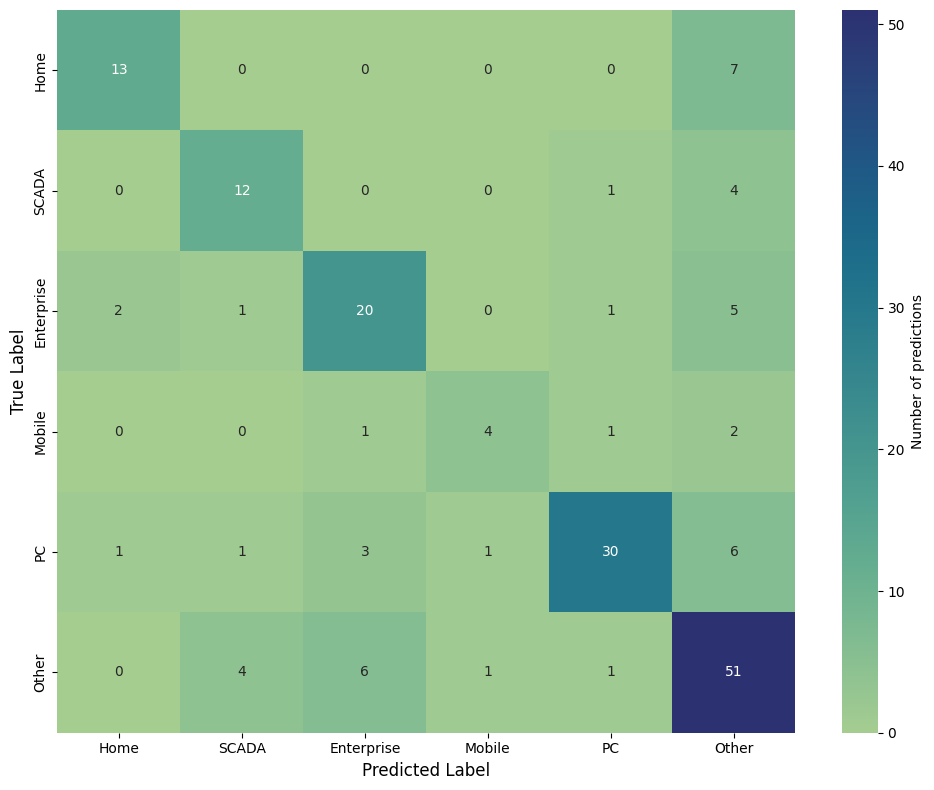

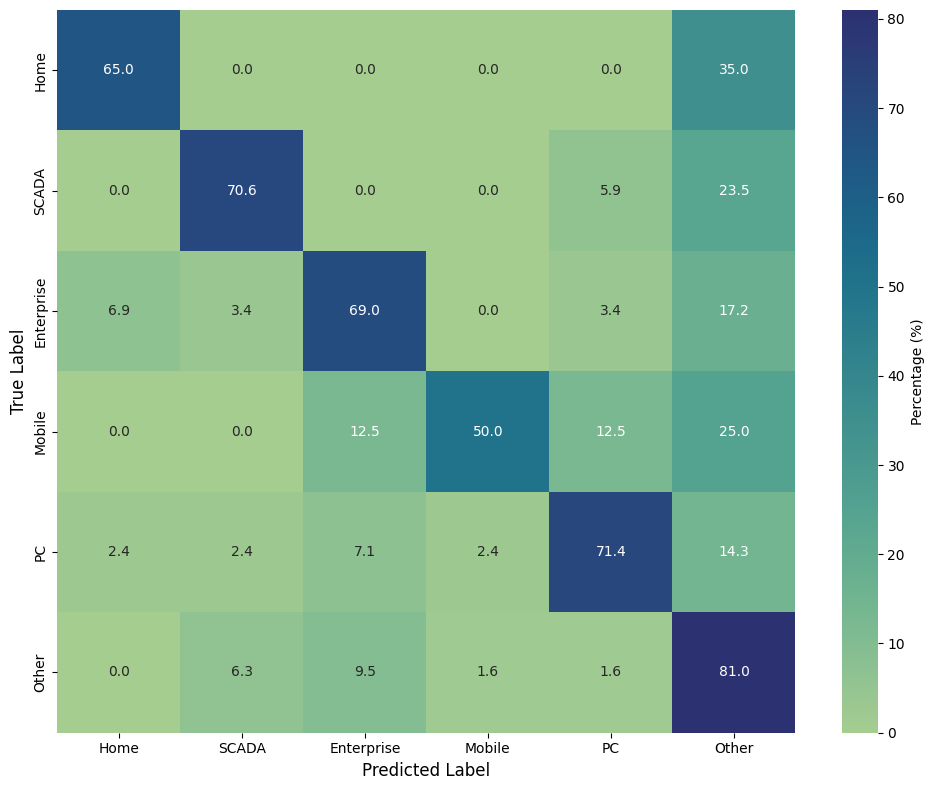


Confusion Matrix Statistics:
Home: 13/20 correct (65.0%)
SCADA: 12/17 correct (70.6%)
Enterprise: 20/29 correct (69.0%)
Mobile: 4/8 correct (50.0%)
PC: 30/42 correct (71.4%)
Other: 51/63 correct (81.0%)

NORMALIZED CONFUSION MATRIX (by row)


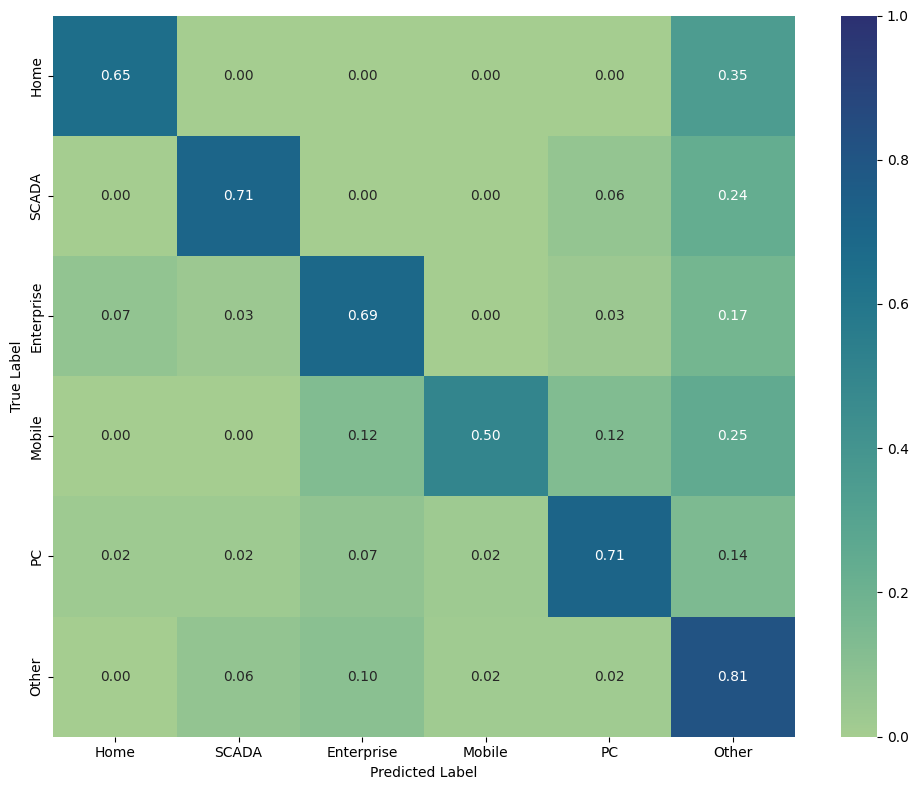


MISCLASSIFICATION ANALYSIS

Most common misclassifications:
  Home → Other: 7 samples
  PC → Other: 6 samples
  Other → Enterprise: 6 samples
  Enterprise → Other: 5 samples
  SCADA → Other: 4 samples
  Other → SCADA: 4 samples
  PC → Enterprise: 3 samples
  Enterprise → Home: 2 samples
  Mobile → Other: 2 samples
  SCADA → PC: 1 samples


In [20]:
# ==================== CONFUSION MATRIX FOR LINEAR SVM ====================
print("\n" + "="*50)
print("CONFUSION MATRIX - LINEAR SVM")
print("="*50)

# Define your desired label order
desired_order = ['Home', 'SCADA', 'Enterprise', 'Mobile', 'PC', 'Other']

# Check if all desired classes exist in the data
for cls in desired_order:
    if cls not in label_encoder.classes_:
        print(f"Warning: Class '{cls}' not found in dataset")

# Create a mapping from desired order to actual labels
label_to_index = {label: idx for idx, label in enumerate(desired_order)}

# Get the confusion matrix for Linear SVM
cm_linear = confusion_matrix(y_test, y_pred_linear)

# Get current labels in the order they appear in the label_encoder
current_labels = label_encoder.classes_

# Reorder the confusion matrix rows and columns to match desired order
if set(desired_order) == set(current_labels):
    # Create index mapping from current order to desired order
    current_to_desired_idx = {label: i for i, label in enumerate(desired_order)}
    desired_to_current_idx = {label: idx for idx, label in enumerate(current_labels)}
    
    # Reorder rows and columns
    reordered_indices = [desired_to_current_idx[label] for label in desired_order]
    cm_reordered = cm_linear[reordered_indices, :][:, reordered_indices]
    
    # Plot the reordered confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_reordered, 
        annot=True, 
        fmt='d',
        cmap='crest',
        xticklabels=desired_order,
        yticklabels=desired_order,
        cbar_kws={'label': 'Number of predictions'}
    )
    
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('../svm/confusion_matrix_linear_svm_reordered.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate percentages for better interpretation
    cm_percentage = cm_reordered.astype('float') / cm_reordered.sum(axis=1)[:, np.newaxis]
    cm_percentage = np.round(cm_percentage * 100, 1)
    
    # Plot percentage confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_percentage, 
        annot=True, 
        fmt='.1f',
        cmap='crest',
        xticklabels=desired_order,
        yticklabels=desired_order,
        cbar_kws={'label': 'Percentage (%)'}
    )
    
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig('../svm/confusion_matrix_linear_svm_percentage.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print some statistics
    print("\nConfusion Matrix Statistics:")
    for i, true_label in enumerate(desired_order):
        total = cm_reordered[i].sum()
        correct = cm_reordered[i, i]
        accuracy_per_class = correct / total * 100 if total > 0 else 0
        print(f"{true_label}: {correct}/{total} correct ({accuracy_per_class:.1f}%)")
        
else:
    print("Warning: Desired labels don't match actual labels in dataset")
    print(f"Desired: {desired_order}")
    print(f"Actual:  {list(current_labels)}")
    
    # Plot with current order
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_linear, 
        annot=True, 
        fmt='d',
        cmap='crest',
        xticklabels=current_labels,
        yticklabels=current_labels
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# ==================== NORMALIZED CONFUSION MATRIX ====================
print("\n" + "="*50)
print("NORMALIZED CONFUSION MATRIX (by row)")
print("="*50)

# Normalize confusion matrix by row (true labels)
cm_normalized = cm_linear.astype('float') / cm_linear.sum(axis=1)[:, np.newaxis]

# Reorder if possible
if set(desired_order) == set(current_labels):
    cm_normalized_reordered = cm_normalized[reordered_indices, :][:, reordered_indices]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized_reordered,
        annot=True,
        fmt='.2f',
        cmap='crest',
        xticklabels=desired_order,
        yticklabels=desired_order,
        vmin=0, vmax=1
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    #plt.title('Normalized Confusion Matrix - SVM)')
    plt.tight_layout()
    plt.savefig('../svm/confusion_matrix_normalized.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# ==================== MISCLASSIFICATION ANALYSIS ====================
print("\n" + "="*50)
print("MISCLASSIFICATION ANALYSIS")
print("="*50)

# Find most common misclassifications
misclassifications = []
for i in range(len(desired_order)):
    for j in range(len(desired_order)):
        if i != j and cm_reordered[i, j] > 0:
            misclassifications.append((desired_order[i], desired_order[j], cm_reordered[i, j]))

# Sort by frequency
misclassifications.sort(key=lambda x: x[2], reverse=True)

print("\nMost common misclassifications:")
for true_label, pred_label, count in misclassifications[:10]:  # Top 10
    print(f"  {true_label} → {pred_label}: {count} samples")

In [21]:

# Visualize results for the best model
#print("\n" + "="*50)
##print("VISUALIZING RESULTS")
#print("="*50)

# Confusion Matrix
#plt.figure(figsize=(10, 8))
#if 'y_pred_rbf' in locals():
#    cm = confusion_matrix(y_test, y_pred_rbf)
#else:
#    cm = confusion_matrix(y_test, y_pred_linear)

#sns.heatmap(
 #   cm, 
  #  annot=True, 
   # fmt='d',
    #cmap='crest',
    #xticklabels=label_encoder.classes_,
   # yticklabels=label_encoder.classes_
#)

#plt.title('Confusion Matrix - SVM Classification')
#plt.xlabel('Predicted Label')
#plt.ylabel('True Label')
#plt.tight_layout()
#plt.show()


In [22]:

# Feature importance (for Linear SVM)
print("\n" + "="*50)
print("TOP IMPORTANT FEATURES PER CLASS")
print("="*50)

if hasattr(best_model, 'coef_'):
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    
    for i, class_name in enumerate(label_encoder.classes_):
        coef = best_model.coef_[i]
        top_indices = np.argsort(coef)[-10:][::-1]  # Top 10 features
        
        print(f"\n{class_name} - Most important features:")
        for idx in top_indices:
            if coef[idx] > 0:  # Only show positive coefficients
                print(f"  {feature_names[idx]}: {coef[idx]:.4f}")

# Cross-validation for robustness check
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)

cv_scores = cross_val_score(
    linear_svm, 
    X_train_tfidf, 
    y_train, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



TOP IMPORTANT FEATURES PER CLASS

CROSS-VALIDATION RESULTS
Cross-validation scores: [0.66433566 0.67132867 0.63636364 0.63380282 0.74647887]
Mean CV accuracy: 0.6705 (+/- 0.0816)


In [23]:

# Test on some random samples
print("\n" + "="*50)
print("TESTING ON RANDOM SAMPLES")
print("="*50)



TESTING ON RANDOM SAMPLES


In [24]:
# Test on some random samples
print("\n" + "="*50)
print("TESTING ON RANDOM SAMPLES")
print("="*50)

# DEBUG: Check what's happening
print(f"len(X_test) = {len(X_test)}")
print(f"X_test.index = {X_test.index[:10]}...")  # Show first 10 indices

# Get some random test samples - FIXED
np.random.seed(42)
# Use numpy.arange to ensure we get positions, not indices
test_positions = np.random.choice(np.arange(len(X_test)), min(5, len(X_test)), replace=False)

print(f"\nSelected positions: {test_positions}")
print(f"Max position should be < {len(X_test)}")

print("\nSample predictions:")
for i, pos in enumerate(test_positions):
    # Verify pos is within bounds
    if pos >= len(y_pred_linear):
        print(f"ERROR: Position {pos} >= {len(y_pred_linear)}")
        continue
        
    actual_text = X_test.iloc[pos][:200] + "..." if len(X_test.iloc[pos]) > 200 else X_test.iloc[pos]
    actual_label = label_encoder.inverse_transform([y_test.iloc[pos]])[0]
    
    if 'y_pred_rbf' in locals():
        if pos < len(y_pred_rbf):
            pred_label = label_encoder.inverse_transform([y_pred_rbf[pos]])[0]
        else:
            print(f"ERROR: Position {pos} out of bounds for y_pred_rbf (size: {len(y_pred_rbf)})")
            continue
    else:
        if pos < len(y_pred_linear):
            pred_label = label_encoder.inverse_transform([y_pred_linear[pos]])[0]
        else:
            print(f"ERROR: Position {pos} out of bounds for y_pred_linear (size: {len(y_pred_linear)})")
            continue
    
    print(f"\nSample {i+1} (position {pos}):")
    print(f"  Text: {actual_text}")
    print(f"  Rule-based: {actual_label}")
    print(f"  SVM Predicted: {pred_label}")
    print(f"  Match: {'Yes' if actual_label == pred_label else 'No'}")


TESTING ON RANDOM SAMPLES
len(X_test) = 179
X_test.index = Index([604, 761, 757, 366, 26, 245, 826, 818, 19, 684], dtype='int64')...

Selected positions: [ 78  16  65 114  76]
Max position should be < 179

Sample predictions:

Sample 1 (position 78):
  Text: Dell System Update (DSU) 1.9 and earlier versions contain a denial of service vulnerability. A local authenticated malicious user with low privileges may potentially exploit this vulnerability to caus...
  Rule-based: Enterprise
  SVM Predicted: Enterprise
  Match: Yes

Sample 2 (position 16):
  Text: An exploitable code execution vulnerability exists in the firmware update functionality of Yi Home Camera 27US 1.8.7.0D. A specially crafted file can cause a logic flaw and command injection, resultin...
  Rule-based: Home
  SVM Predicted: Home
  Match: Yes

Sample 3 (position 65):
  Text: The Emerson ControlWave 'Next Generation' RTUs through 2022-05-02 mishandle firmware integrity. They utilize the BSAP-IP protocol to transmit firm

In [25]:
# Save the model and vectorizer
print("\n" + "="*50)
print("SAVING MODEL")
print("="*50)

import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save model and vectorizer
joblib.dump(best_model, 'models/svm_iot_classifier.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

print("Model saved to 'models/' directory:")
print("  - svm_iot_classifier.pkl")
print("  - tfidf_vectorizer.pkl")
print("  - label_encoder.pkl")

# Function to predict new CVEs
def predict_cve_iot_class(description, vendor="", product=""):
    """Predict IoT class for a new CVE"""
    combined_text = f"{description} {vendor} {product}"
    
    # Load models
    vectorizer = joblib.load('models/tfidf_vectorizer.pkl')
    model = joblib.load('models/svm_iot_classifier.pkl')
    encoder = joblib.load('models/label_encoder.pkl')
    
    # Transform and predict
    text_tfidf = vectorizer.transform([combined_text])
    prediction = model.predict(text_tfidf)
    predicted_class = encoder.inverse_transform(prediction)[0]
    
    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_tfidf)[0]
        prob_dict = {encoder.inverse_transform([i])[0]: prob for i, prob in enumerate(probabilities)}
        return predicted_class, prob_dict
    else:
        return predicted_class, None

print("\n" + "="*50)
print("PREDICTION FUNCTION READY")
print("="*50)
print("\nYou can use predict_cve_iot_class(description, vendor, product) to classify new CVEs")


SAVING MODEL
Model saved to 'models/' directory:
  - svm_iot_classifier.pkl
  - tfidf_vectorizer.pkl
  - label_encoder.pkl

PREDICTION FUNCTION READY

You can use predict_cve_iot_class(description, vendor, product) to classify new CVEs


## Over-sampling minority classes (SMOTE-like approach)


OVER-SAMPLING EXPERIMENT - BALANCING IMBALANCED DATA

1. ORIGINAL CLASS DISTRIBUTION:
Other         312
PC            208
Enterprise    146
Home          102
SCADA          86
Mobile         38
Name: count, dtype: int64

2. RESAMPLING DETAILS:
   Majority class: Other
   Majority size: 249
   Mobile: Over-sampled from 30 to 249
   Enterprise: Over-sampled from 117 to 249
   PC: Over-sampled from 166 to 249
   SCADA: Over-sampled from 69 to 249
   Home: Over-sampled from 82 to 249

3. BALANCED TRAINING SET DISTRIBUTION:
PC            249
Home          249
Other         249
Enterprise    249
Mobile        249
SCADA         249
Name: count, dtype: int64

4. RE-TRAINING TF-IDF ON BALANCED DATA...
   Balanced training features shape: (1494, 5000)
   Test features shape: (179, 5000)

5. TRAINING LINEAR SVM ON BALANCED DATA...

6. EVALUATION RESULTS - BALANCED LINEAR SVM:
Accuracy: 0.7151
F1-Score (weighted): 0.7128

Classification Report (Balanced Model):
              precision    recall  

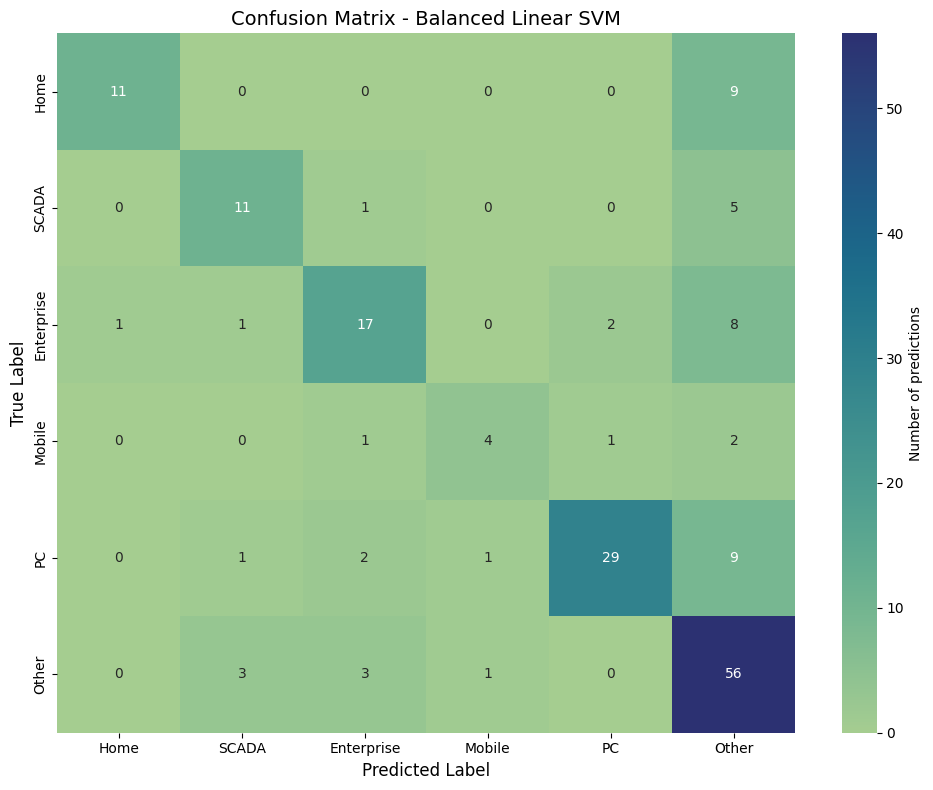


Confusion Matrix Statistics (Balanced Model):
Home: 11/20 correct (55.0%)
SCADA: 11/17 correct (64.7%)
Enterprise: 17/29 correct (58.6%)
Mobile: 4/8 correct (50.0%)
PC: 29/42 correct (69.0%)
Other: 56/63 correct (88.9%)

Normalized Confusion Matrix (Balanced Model):


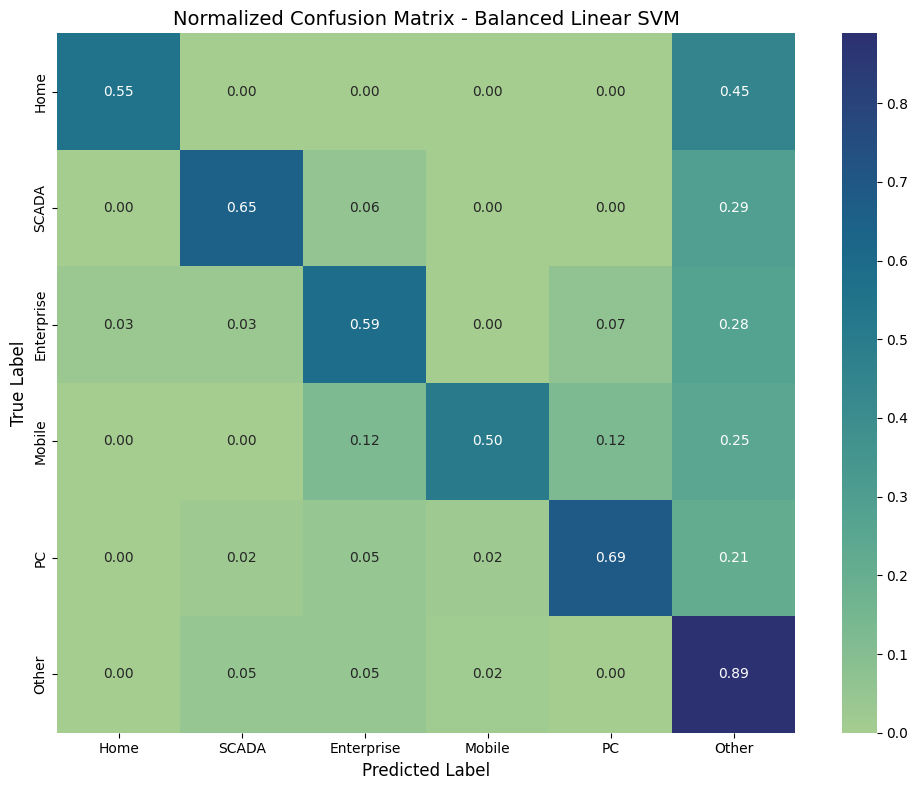

Normalized confusion matrix saved as 'confusion_matrix_balanced_normalized.pdf'

9. CROSS-VALIDATION ON BALANCED MODEL:
Cross-validation scores: [0.90301003 0.89632107 0.91973244 0.92976589 0.93959732]
Mean CV accuracy: 0.9177 (+/- 0.0323)

Original CV accuracy: 0.6705 (+/- 0.0816)
Balanced CV accuracy: 0.9177 (+/- 0.0323)

10. SAVING BALANCED MODEL:
Balanced experimental model saved to 'models_balanced_experiment/' directory:
  - svm_iot_classifier_balanced.pkl
  - tfidf_vectorizer_balanced.pkl
  - label_encoder_balanced.pkl

11. TESTING BALANCED MODEL ON RANDOM SAMPLES:

Sample predictions (Balanced Model):

Sample 1 (position 78):
  Text: Dell System Update (DSU) 1.9 and earlier versions contain a denial of service vulnerability. A local authenticated malicious user with low privileges may potentially exploit this vulnerability to caus...
  Rule-based: Enterprise
  SVM Predicted: Enterprise
  Match: Yes

Sample 2 (position 16):
  Text: An exploitable code execution vulnerability exi

In [26]:
# ==================== OVER-SAMPLING EXPERIMENT ====================
print("\n" + "="*60)
print("OVER-SAMPLING EXPERIMENT - BALANCING IMBALANCED DATA")
print("="*60)

from sklearn.utils import resample

# Store original data for comparison
X_original = X.copy()
y_original = y.copy()
X_train_original = X_train.copy()
X_test_original = X_test.copy()
y_train_original = y_train.copy()
y_test_original = y_test.copy()

print("\n1. ORIGINAL CLASS DISTRIBUTION:")
original_counts = pd.Series(y_original).value_counts()
original_counts.index = label_encoder.inverse_transform(original_counts.index)
print(original_counts)

# Convert to DataFrame for resampling
train_df = pd.DataFrame({
    'combined_text': X_train_original,
    'label': y_train_original
})

# Get the majority class size
majority_class = train_df['label'].value_counts().idxmax()
majority_size = train_df['label'].value_counts().max()

print(f"\n2. RESAMPLING DETAILS:")
print(f"   Majority class: {label_encoder.inverse_transform([majority_class])[0]}")
print(f"   Majority size: {majority_size}")

# Balance each minority class in training data
balanced_data = []

for class_label in train_df['label'].unique():
    class_data = train_df[train_df['label'] == class_label]
    
    if len(class_data) < majority_size:
        # Over-sample minority classes
        class_data_resampled = resample(
            class_data,
            replace=True,
            n_samples=majority_size,
            random_state=42
        )
        class_name = label_encoder.inverse_transform([class_label])[0]
        print(f"   {class_name}: Over-sampled from {len(class_data)} to {majority_size}")
        balanced_data.append(class_data_resampled)
    else:
        # Keep as is
        balanced_data.append(class_data)

# Combine balanced data
train_df_balanced = pd.concat(balanced_data, ignore_index=True)
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Split back to X_train and y_train
X_train_balanced = train_df_balanced['combined_text']
y_train_balanced = train_df_balanced['label']

print(f"\n3. BALANCED TRAINING SET DISTRIBUTION:")
balanced_counts = pd.Series(y_train_balanced).value_counts()
balanced_counts.index = label_encoder.inverse_transform(balanced_counts.index)
print(balanced_counts)

# Re-transform TF-IDF with balanced training data
print("\n4. RE-TRAINING TF-IDF ON BALANCED DATA...")
X_train_tfidf_balanced = tfidf_vectorizer.fit_transform(X_train_balanced)
X_test_tfidf_balanced = tfidf_vectorizer.transform(X_test_original)  # Use original test set

print(f"   Balanced training features shape: {X_train_tfidf_balanced.shape}")
print(f"   Test features shape: {X_test_tfidf_balanced.shape}")

print("\n5. TRAINING LINEAR SVM ON BALANCED DATA...")
linear_svm_balanced = LinearSVC(
    C=1.0,
    class_weight='balanced',
    random_state=42,
    max_iter=2000
)

linear_svm_balanced.fit(X_train_tfidf_balanced, y_train_balanced)

# Make predictions
y_pred_balanced = linear_svm_balanced.predict(X_test_tfidf_balanced)

print("\n6. EVALUATION RESULTS - BALANCED LINEAR SVM:")
print("="*60)

accuracy_balanced = accuracy_score(y_test_original, y_pred_balanced)
print(f"Accuracy: {accuracy_balanced:.4f}")
print(f"F1-Score (weighted): {f1_score(y_test_original, y_pred_balanced, average='weighted'):.4f}")

print("\nClassification Report (Balanced Model):")
print(classification_report(
    y_test_original, 
    y_pred_balanced, 
    target_names=label_encoder.classes_,
    digits=4
))

# Compare with original model
print("\n7. COMPARISON WITH ORIGINAL MODEL:")
print("="*60)
print(f"{'Metric':<20} {'Original':<12} {'Balanced':<12} {'Difference':<12}")
print("-" * 60)
print(f"{'Accuracy':<20} {accuracy_linear:<12.4f} {accuracy_balanced:<12.4f} {accuracy_balanced-accuracy_linear:<+12.4f}")

# Calculate F1 scores per class for comparison
from sklearn.metrics import f1_score

f1_original = f1_score(y_test_original, y_pred_linear, average=None)
f1_balanced = f1_score(y_test_original, y_pred_balanced, average=None)

print(f"\n{'Class':<15} {'F1 (Original)':<15} {'F1 (Balanced)':<15} {'Improvement':<15}")
print("-" * 60)
for i, class_name in enumerate(label_encoder.classes_):
    improvement = f1_balanced[i] - f1_original[i]
    print(f"{class_name:<15} {f1_original[i]:<15.4f} {f1_balanced[i]:<15.4f} {improvement:<+15.4f}")

print("\n8. CONFUSION MATRIX - BALANCED MODEL:")
print("="*60)

cm_balanced = confusion_matrix(y_test_original, y_pred_balanced)

# Reorder if possible
if set(desired_order) == set(label_encoder.classes_):
    desired_to_current_idx = {label: idx for idx, label in enumerate(label_encoder.classes_)}
    reordered_indices = [desired_to_current_idx[label] for label in desired_order]
    cm_balanced_reordered = cm_balanced[reordered_indices, :][:, reordered_indices]
    
    # Plot balanced confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_balanced_reordered, 
        annot=True, 
        fmt='d',
        cmap='crest',
        xticklabels=desired_order,
        yticklabels=desired_order,
        cbar_kws={'label': 'Number of predictions'}
    )
    
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix - Balanced Linear SVM', fontsize=14)
    plt.tight_layout()
    plt.savefig('../svm/confusion_matrix_balanced_experiment.pdf', dpi=300, bbox_inches='tight')
    plt.show()



    
    
    # Print statistics
    print("\nConfusion Matrix Statistics (Balanced Model):")
    for i, true_label in enumerate(desired_order):
        total = cm_balanced_reordered[i].sum()
        correct = cm_balanced_reordered[i, i]
        accuracy_per_class = correct / total * 100 if total > 0 else 0
        print(f"{true_label}: {correct}/{total} correct ({accuracy_per_class:.1f}%)")





# ===== NORMALIZED CONFUSION MATRIX (0.xx format) =====
print("\nNormalized Confusion Matrix (Balanced Model):")
print("=" * 60)

# Compute normalized confusion matrix (row-wise normalization)
cm_balanced_normalized = cm_balanced_reordered.astype('float') / cm_balanced_reordered.sum(axis=1)[:, np.newaxis]

# Replace NaN with 0 (in case of empty rows)
cm_balanced_normalized = np.nan_to_num(cm_balanced_normalized)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_balanced_normalized,
    annot=True,
    fmt=".2f",
    cmap="crest",
    xticklabels=desired_order,
    yticklabels=desired_order,
    #cbar_kws={'label': 'Proportion of predictions'}
)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix - Balanced Linear SVM', fontsize=14)
plt.tight_layout()

# Save normalized confusion matrix
plt.savefig('../svm/confusion_matrix_balanced_normalized.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Normalized confusion matrix saved as 'confusion_matrix_balanced_normalized.pdf'")


# Cross-validation on balanced model
print("\n9. CROSS-VALIDATION ON BALANCED MODEL:")
print("="*60)

cv_scores_balanced = cross_val_score(
    linear_svm_balanced, 
    X_train_tfidf_balanced, 
    y_train_balanced, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)








print(f"Cross-validation scores: {cv_scores_balanced}")
print(f"Mean CV accuracy: {cv_scores_balanced.mean():.4f} (+/- {cv_scores_balanced.std() * 2:.4f})")

# Compare cross-validation results
print(f"\nOriginal CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Balanced CV accuracy: {cv_scores_balanced.mean():.4f} (+/- {cv_scores_balanced.std() * 2:.4f})")

# Save balanced model separately
print("\n10. SAVING BALANCED MODEL:")
print("="*60)

os.makedirs('models_balanced_experiment', exist_ok=True)

joblib.dump(linear_svm_balanced, 'models_balanced_experiment/svm_iot_classifier_balanced.pkl')
joblib.dump(tfidf_vectorizer, 'models_balanced_experiment/tfidf_vectorizer_balanced.pkl')
joblib.dump(label_encoder, 'models_balanced_experiment/label_encoder_balanced.pkl')

print("Balanced experimental model saved to 'models_balanced_experiment/' directory:")
print("  - svm_iot_classifier_balanced.pkl")
print("  - tfidf_vectorizer_balanced.pkl")
print("  - label_encoder_balanced.pkl")

# Test balanced model on random samples
print("\n11. TESTING BALANCED MODEL ON RANDOM SAMPLES:")
print("="*60)

np.random.seed(42)
test_positions = np.random.choice(np.arange(len(X_test_original)), min(5, len(X_test_original)), replace=False)

print("\nSample predictions (Balanced Model):")
for i, pos in enumerate(test_positions):
    actual_text = X_test_original.iloc[pos][:200] + "..." if len(X_test_original.iloc[pos]) > 200 else X_test_original.iloc[pos]
    actual_label = label_encoder.inverse_transform([y_test_original.iloc[pos]])[0]
    pred_label = label_encoder.inverse_transform([y_pred_balanced[pos]])[0]
    
    print(f"\nSample {i+1} (position {pos}):")
    print(f"  Text: {actual_text}")
    print(f"  Rule-based: {actual_label}")
    print(f"  SVM Predicted: {pred_label}")
    print(f"  Match: {'Yes' if actual_label == pred_label else 'No'}")

# Summary of experiment
print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print("Original model trained on imbalanced data")
print("Balanced model trained on over-sampled data")
print("Both models tested on same test set")
print("Results saved separately for comparison")
print("Balanced model saved in 'models_balanced_experiment/'")
print("\nKey findings:")
if accuracy_balanced > accuracy_linear:
    print(f"  • Balanced model improved accuracy by {accuracy_balanced-accuracy_linear:.4f}")
else:
    print(f"  • Balanced model decreased accuracy by {accuracy_linear-accuracy_balanced:.4f}")
    
# Check if minority classes improved
minority_classes = ['Home', 'SCADA', 'Mobile']  # Adjust based on your data
for i, class_name in enumerate(label_encoder.classes_):
    if class_name in minority_classes:
        if f1_balanced[i] > f1_original[i]:
            print(f"  • {class_name} F1-score improved by {f1_balanced[i]-f1_original[i]:.4f}")